## LLM Prompt Engineering with few-shot learning for product description generation

---

### Notebook Summary

This notebook processes a Kaggle Flipkart product dataset, setting up Bedrock pipeline in Sagemaker for inferencing a Sonnet 3.5 LLM and computing BERT score for product description generation based on few-shot examples.

Additionally, contains input and output token number and cost calculation for AWS.

---

### Task: Product description generation

- Dataset: Flipkart Products [kaggle.com/flipkart-products/](https://www.kaggle.com/datasets/PromptCloudHQ/flipkart-products/data/)

- Test_set input: product_name, product_specifications, brand, retail and discounted prices.

- Output: description

Took only samples that belong to "Jewellery >> Necklaces & Chains >> Necklaces" product_category_tree. This comes to about 1500 different flipkart products.

### Approach: few-shot learning

- Cloud: AWS

- Tools: Bedrock, Sagemaker

- LLM: Llama LLM-3.1-8B model, Anthropic Claude Sonnet 3.5 v1

- Eval metrics: BERTScore


### Imports

In [ ]:
import os
import time
import random
import json
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import torch

import matplotlib.pyplot as plt

from langchain_core.prompts import FewShotPromptTemplate, PromptTemplate, SystemMessagePromptTemplate, ChatPromptTemplate

from transformers import AutoTokenizer

from evaluate import load
import bert_score
from bert_score import BERTScorer, plot_example

import boto3
from botocore.exceptions import ClientError

from tools import log_exp

In [187]:
# Seeding
seed = 476

torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

### Constants

In [147]:
# Model Hyperparameters
temperature = 0.1
max_output_token = 200
top_p = 0.9

In [ ]:
# Token calculation constans over AWS
calculate_tokens = False
llama3_1_8B_cost = 0.0002 / 1000
sonnet_input_cost = 0.0003 / 1000
sonnet_output_cost = 0.015 / 1000

model_input_cost = sonnet_input_cost
model_output_cost = sonnet_input_cost

In [ ]:
# Set huggingface token for token embedding

from huggingface_hub import login

login(os.getenv("HF_TOKEN"))

### Data engineering

In [2]:
# Load data
df = pd.read_csv("data/flipkart_com-ecommerce_sample.csv")

In [6]:
# Filtering based on product category and output length
lower_quantile = 0.05
upper_quantile = 0.935

cat_filtered = df[df["product_category_tree"] == "[\"Jewellery >> Necklaces & Chains >> Necklaces\"]"]

lengths = cat_filtered["description"].str.len()

lower_bound = lengths.quantile(lower_quantile)
upper_bound = lengths.quantile(upper_quantile)

print(f"Lower bound ({lower_quantile*100:.0f}th percentile length): {lower_bound}")
print(f"Upper bound ({upper_quantile*100:.0f}th percentile length): {upper_bound}")

filtered = cat_filtered[(lengths >= lower_bound) & (lengths <= upper_bound)]

print("\nOriginal dataset size: ", len(df))
print(f"Filtered shape: {filtered.shape}")

Lower bound (5th percentile length): 167.60000000000002
Upper bound (94th percentile length): 308.0

Original dataset size:  20000
Filtered shape: (1387, 15)


In [ ]:
# Selecting column wich are fed to the model
pd.set_option('display.max_colwidth', None)
dataset = filtered[["product_specifications", "brand", "product_name", 
                    "retail_price", "discounted_price", "description"]]
dataset[:5]

,product_specifications,brand,product_name,retail_price,discounted_price,description
4026,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""Trove""}, {""key""=>""Collection"", ""value""=>""Fusion""}, {""key""=>""Model Number"", ""value""=>""TRN1004BL""}, {""key""=>""Precious/Artificial Jewellery"", ""value""=>""Fashion Jewellery""}, {""key""=>""Type"", ""value""=>""Necklace""}, {""key""=>""Ideal For"", ""value""=>""Women, Girls""}, {""key""=>""Occasion"", ""value""=>""Everyday, Workwear""}, {""key""=>""Color"", ""value""=>""Black, Gold""}, {""key""=>""Base Material"", ""value""=>""Resin""}]}",Trove,Trove Resin Necklace,799.0,350.0,Trove Resin Necklace - Buy Trove Resin Necklace only for Rs. 350 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!
4029,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""Youshine""}, {""key""=>""Precious/Artificial Jewellery"", ""value""=>""Fashion Jewellery""}, {""key""=>""Model Number"", ""value""=>""Neck20248""}, {""key""=>""Type"", ""value""=>""Necklace""}, {""key""=>""Base Material"", ""value""=>""Metal""}, {""key""=>""Pack of"", ""value""=>""1""}]}",Youshine,Youshine Metal Necklace,295.0,148.0,Youshine Metal Necklace - Buy Youshine Metal Necklace only for Rs. 148 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!
4030,"{""product_specification""=>[{""key""=>""Brand"", ""value""=>""Voylla""}, {""key""=>""Model Number"", ""value""=>""CMBLR20145""}, {""key""=>""Precious/Artificial Jewellery"", ""value""=>""Fashion Jewellery""}, {""key""=>""Type"", ""value""=>""Necklace""}, {""key""=>""Ideal For"", ""value""=>""Women""}, {""key""=>""Occasion"", ""value""=>""Everyday""}, {""key""=>""Color"", ""value""=>""Multicolor""}, {""key""=>""Base Material"", ""value""=>""Metal, Alloy""}, {""key""=>""Necklace Type"", ""value""=>""Strings""}, {""key""=>""Sales Package"", ""value""=>""1 Necklace""}, {""key""=>""Pack of"", ""value""=>""1""}, {""key""=>""Certification"", ""value""=>""NA""}]}",Voylla,"Voylla Metal, Alloy Necklace",410.0,369.0,"Voylla Metal, Alloy Necklace - Buy Voylla Metal, Alloy Necklace only for Rs. 369 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!"
4032,"{""product_specification""=>[{""key""=>""Collection"", ""value""=>""Designer""}, {""key""=>""Brand"", ""value""=>""Zaicus""}, {""key""=>""Precious/Artificial Jewellery"", ""value""=>""Fashion Jewellery""}, {""key""=>""Model Number"", ""value""=>""Vintage Rivets Choker Statement""}, {""key""=>""Type"", ""value""=>""Necklace""}, {""key""=>""Model Name"", ""value""=>""Vintage Rivets Choker Statement""}, {""key""=>""Occasion"", ""value""=>""Everyday""}, {""key""=>""Ideal For"", ""value""=>""Women, Girls""}, {""key""=>""Color"", ""value""=>""Multicolor""}, {""key""=>""Base Material"", ""value""=>""Alloy""}]}",Zaicus,Zaicus Vintage Rivets Choker Statement Alloy Necklace,699.0,199.0,Zaicus Vintage Rivets Choker Statement Alloy Necklace - Buy Zaicus Vintage Rivets Choker Statement Alloy Necklace only for Rs. 199 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!
4035,"{""product_specification""=>[{""key""=>""Pearl Type"", ""value""=>""NA""}, {""key""=>""Brand"", ""value""=>""UpTown""}, {""key""=>""Collection"", ""value""=>""Designer""}, {""key""=>""Model Number"", ""value""=>""KJ15N072""}, {""key""=>""Precious/Artificial Jewellery"", ""value""=>""Fashion Jewellery""}, {""key""=>""Type"", ""value""=>""Necklace""}, {""key""=>""Ideal For"", ""value""=>""Women, Girls""}, {""key""=>""Occasion"", ""value""=>""Everyday""}, {""key""=>""Color"", ""value""=>""Black, Gold""}, {""key""=>""Diamond Color Grade"", ""value""=>""NA""}, {""key""=>""Diamond Clarity"", ""value""=>""NA""}, {""key""=>""Gold Purity"", ""value""=>""NA K""}, {""key""=>""Weight"", ""value""=>""80 g""}, {""key""=>""Height"", ""value""=>""230 mm""}, {"

In [ ]:
# Transforming specifications
pair_list = []
for spec in filtered["product_specifications"]:
    spec_dict = {}
    for pair in json.loads(spec.replace("=>", ":"))["product_specification"]:
        spec_dict[pair['key']] = pair['value']
    pair_list.append(spec_dict)

pair_list[0]

{'Brand': 'Trove',
 'Collection': 'Fusion',
 'Model Number': 'TRN1004BL',
 'Precious/Artificial Jewellery': 'Fashion Jewellery',
 'Type': 'Necklace',
 'Ideal For': 'Women, Girls',
 'Occasion': 'Everyday, Workwear',
 'Color': 'Black, Gold',
 'Base Material': 'Resin'}

In [ ]:
# Finding most significant outliers

lengths = {}
for pairs in pair_list:
    for key, value in pairs.items():
        try:
            lengths[key].append(len(value))
        except KeyError:
            lengths[key] = [len(value)]

averages = [np.mean(lens) for lens in lengths.values()]
op = Counter(dict(zip(lengths.keys(), averages))).most_common()
asc_d = list(op)

asc_d[:5]

[('Decorative Features', 56.8),
 ('Covered in Warranty', 55.25),
 ('Warranty Summary', 54.52325581395349),
 ('Not Covered in Warranty', 35.166666666666664),
 ('Other Features', 35.083333333333336)]

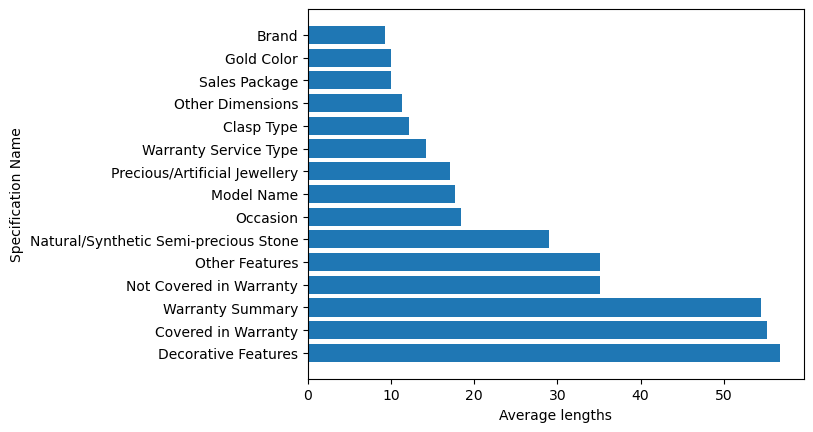

In [15]:
# Visualizing outliers

fig, ax = plt.subplots()
ax.barh([d[0] for d in asc_d[:15]], [d[1] for d in asc_d[:15]])
plt.xlabel("Average lengths")
plt.ylabel("Specification Name")

plt.show()

In [ ]:
# Exploring longest values from select specification
for pairs in pair_list:
    for key, value in pairs.items():
        if key == "Decorative Features":
            print(value)

Feather Charm Pendant, Beautiful Multicolor
Heavy Look With Charm Pendants
Giftwallas Exclusive Multicolor Stones Party Wear Necklace For Women
Giftwallas Exclusive Golden Collections Fancy Moti Necklace For Women
Giftwallas Exclusive Gold Plated with Red Stone Classic Necklace For Women


In [155]:
# Length distribution for highest average length specifications
for great in [d[0] for d in asc_d[:5]]:
    print(lengths[great])

[43, 30, 68, 69, 74]
[65, 65, 65, 65, 65, 65, 26, 65, 65, 26, 65, 26]
[59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 25, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 25, 59, 59, 59, 59, 59, 25, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 25, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 8, 8, 11, 11, 8]
[20, 87, 32, 20, 32, 20]
[78, 78, 78, 78, 78, 6, 78, 6, 78, 26, 8, 21, 8, 8, 21, 8, 8, 26, 8, 21, 79, 8, 8, 26]


In [ ]:
def accept_specification(key, value) -> bool:
    """
    Accepts or rejects values based on relevance and length.
    """
    stop_specifications = ["Warranty Service Type", "Not Covered in Warranty", "Brand", "Name"]
    if key in stop_specifications:
        return False
    if value == "The product is covered under 30 days Replacement Guarantee.":
        value = "30 days replacement guarantee"
    elif value == "Warranty Against Any Manufacturing Defect. The Warranty Is For 6 Months":
        value = "6 Months Warranty"
    return True

In [ ]:
# Format specification dictionary to a string
spec_list = []
for pairs in pair_list:
    specification = ""
    for key, value in pairs.items():
        if accept_specification(key, value):
            specification += key + ": " + value + ", "
    spec_list.append(specification[:-2])

spec_list[0]

'Collection: Fusion, Model Number: TRN1004BL, Precious/Artificial Jewellery: Fashion Jewellery, Type: Necklace, Ideal For: Women, Girls, Occasion: Everyday, Workwear, Color: Black, Gold, Base Material: Resin'

In [159]:
dataset["product_specifications"] = spec_list
dataset

,product_specifications,brand,product_name,retail_price,discounted_price,description
0,"Collection: Fusion, Model Number: TRN1004BL, Precious/Artificial Jewellery: Fashion Jewellery, Type: Necklace, Ideal For: Women, Girls, Occasion: Everyday, Workwear, Color: Black, Gold, Base Material: Resin",Trove,Trove Resin Necklace,799.0,350.0,Trove Resin Necklace - Buy Trove Resin Necklace only for Rs. 350 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!
1,"Precious/Artificial Jewellery: Fashion Jewellery, Model Number: Neck20248, Type: Necklace, Base Material: Metal, Pack of: 1",Youshine,Youshine Metal Necklace,295.0,148.0,Youshine Metal Necklace - Buy Youshine Metal Necklace only for Rs. 148 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!
2,"Model Number: CMBLR20145, Precious/Artificial Jewellery: Fashion Jewellery, Type: Necklace, Ideal For: Women, Occasion: Everyday, Color: Multicolor, Base Material: Metal, Alloy, Necklace Type: Strings, Sales Package: 1 Necklace, Pack of: 1, Certification: NA",Voylla,"Voylla Metal, Alloy Necklace",410.0,369.0,"Voylla Metal, Alloy Necklace - Buy Voylla Metal, Alloy Necklace only for Rs. 369 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!"
3,"Collection: Designer, Precious/Artificial Jewellery: Fashion Jewellery, Model Number: Vintage Rivets Choker Statement, Type: Necklace, Model Name: Vintage Rivets Choker Statement, Occasion: Everyday, Ideal For: Women, Girls, Color: Multicolor, Base Material: Alloy",Zaicus,Zaicus Vintage Rivets Choker Statement Alloy Necklace,699.0,199.0,Zaicus Vintage Rivets Choker Statement Alloy Necklace - Buy Zaicus Vintage Rivets Choker Statement Alloy Necklace only for Rs. 199 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!
4,"Pearl Type: NA, Collection: Designer, Model Number: KJ15N072, Precious/Artificial Jewellery: Fashion Jewellery, Type: Necklace, Ideal For: Women, Girls, Occasion: Everyday, Color: Black, Gold, Diamond Color Grade: NA, Diamond Clarity: NA, Gold Purity: NA K, Weight: 80 g, Height: 230 mm, Width: 50 mm, Depth: 1 mm, Base Material: Metal, Alloy, Gemstone: NA, Necklace Type: Designer, Chain Type: Belcher, Setting: Bezel, Clasp Type: Lobster Claw, Sales Package: 1 Necklace, Pack of: 1, Certification: NA",UpTown,"UpTown Metal, Alloy Necklace",500.0,399.0,"UpTown Metal, Alloy Necklace - Buy UpTown Metal, Alloy Necklace only for Rs. 399 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!"
...,...,...,...,...,...,...
1449,"Model Number: GCC18/512465, Precious/Artificial Jewellery: Precious Jewellery, Type: Necklace, Ideal For: Women, Occasion: Workwear, Color: Multicolor, Gold Purity: 18 K, Gold Weight: 7.600 g, Weight: 24.690 g, Base Material: Gold, Pack of: 1, Certification: BIS Hallmark",Jewelmantra,Jewelmantra Gold Necklace,26800.0,26800.0,Jewelmantra Gold Necklace - Buy Jewelmantra Gold Necklace only for Rs. 26800 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!
1450,"Precious/Artificial Jewellery: Semi Precious Jewellery, Model Number: 1456, Type: Necklace, Occasion: Everyday, Ideal For: Women, Girls, Color: Turquoise, Purple, Amethyst Color: Purple, Chain/Necklace Length: 24 inch, Base Material: Stone, Gemstone: Turquoise, Amethyst, Plating: Brass, Pack of: 1",Glam Accessories,"Glam Accessories Turquoise, Amethyst Brass Plated Stone Necklace",549.0,499.0,"Glam Accessories Turquoise, Amethyst Brass Plated Stone Necklace - Buy Glam Accessories Turquoise, Amethyst Brass Plated Stone Necklace only for Rs. 499 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!"
1451,"Collection: Designer, Model Number: RDN00056VVS-GH_18K (750), Precious/Artificial Jewellery: Precious Jewellery

In [160]:
def format_row_to_feed(inp) -> str:
    """Formats a single DataFrame row into a string to be given to a prompt."""
    return f'Name: {inp["product_name"]}, Brand: {inp["brand"]}, \
        Retail Price: {inp["retail_price"]}, Discounted Price: {inp["discounted_price"]}, \
        Specifications: {inp["product_specifications"]}.'

In [161]:
def format_values_to_feed(inp) -> str:
    """Formats a single value list into a string to be given to a prompt."""
    return f'Specifications: {inp[0]}, Brand: {inp[1]}, \
    Name: {inp[2]}, Retail Price: {inp[3]}, Discounted Price: {inp[4]}.'

In [162]:
# Setting outputs
outputs = filtered["description"]

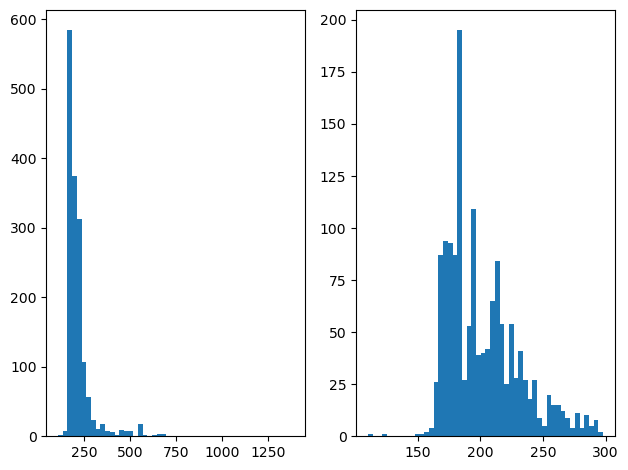

In [ ]:
# Visualizing output length distribution before and after removing outliers

fig, axs = plt.subplots(1, 2, tight_layout=True)
axs[0].hist([len(output) for output in cat_filtered["description"]], bins=50)
axs[1].hist([len(output) for output in outputs], bins=50)

plt.show()

In [168]:
# Removing breaks

for i, row in dataset.iterrows():
    row["description"] = row["description"].replace("\\n", "")
    row["description"] = row["description"].replace("\\t", "")
dataset = dataset.reset_index(drop=True)
dataset.head()

,product_specifications,brand,product_name,retail_price,discounted_price,description
0,"Collection: Fusion, Model Number: TRN1004BL, Precious/Artificial Jewellery: Fashion Jewellery, Type: Necklace, Ideal For: Women, Girls, Occasion: Everyday, Workwear, Color: Black, Gold, Base Material: Resin",Trove,Trove Resin Necklace,799.0,350.0,Trove Resin Necklace - Buy Trove Resin Necklace only for Rs. 350 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!
1,"Precious/Artificial Jewellery: Fashion Jewellery, Model Number: Neck20248, Type: Necklace, Base Material: Metal, Pack of: 1",Youshine,Youshine Metal Necklace,295.0,148.0,Youshine Metal Necklace - Buy Youshine Metal Necklace only for Rs. 148 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!
2,"Model Number: CMBLR20145, Precious/Artificial Jewellery: Fashion Jewellery, Type: Necklace, Ideal For: Women, Occasion: Everyday, Color: Multicolor, Base Material: Metal, Alloy, Necklace Type: Strings, Sales Package: 1 Necklace, Pack of: 1, Certification: NA",Voylla,"Voylla Metal, Alloy Necklace",410.0,369.0,"Voylla Metal, Alloy Necklace - Buy Voylla Metal, Alloy Necklace only for Rs. 369 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!"
3,"Collection: Designer, Precious/Artificial Jewellery: Fashion Jewellery, Model Number: Vintage Rivets Choker Statement, Type: Necklace, Model Name: Vintage Rivets Choker Statement, Occasion: Everyday, Ideal For: Women, Girls, Color: Multicolor, Base Material: Alloy",Zaicus,Zaicus Vintage Rivets Choker Statement Alloy Necklace,699.0,199.0,Zaicus Vintage Rivets Choker Statement Alloy Necklace - Buy Zaicus Vintage Rivets Choker Statement Alloy Necklace only for Rs. 199 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!
4,"Pearl Type: NA, Collection: Designer, Model Number: KJ15N072, Precious/Artificial Jewellery: Fashion Jewellery, Type: Necklace, Ideal For: Women, Girls, Occasion: Everyday, Color: Black, Gold, Diamond Color Grade: NA, Diamond Clarity: NA, Gold Purity: NA K, Weight: 80 g, Height: 230 mm, Width: 50 mm, Depth: 1 mm, Base Material: Metal, Alloy, Gemstone: NA, Necklace Type: Designer, Chain Type: Belcher, Setting: Bezel, Clasp Type: Lobster Claw, Sales Package: 1 Necklace, Pack of: 1, Certification: NA",UpTown,"UpTown Metal, Alloy Necklace",500.0,399.0,"UpTown Metal, Alloy Necklace - Buy UpTown Metal, Alloy Necklace only for Rs. 399 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!"


### Token number calculation

In [26]:
# Loading tokenizer for token calculation

if calculate_tokens:
    tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.1-8B")
    tokenizer.encode("Meta bad")

In [ ]:
# Calculate the number of output tokens
if calculate_tokens:
    output_token_count = 0
    output_token_lengths = []
    
    for output in outputs:
        v = tokenizer.encode(output)
        output_token_count += len(v)
        output_token_lengths.append(len(v))

    print("Number of tokens for all output: ", output_token_count)

In [ ]:
# Calculate the number of input tokens
if calculate_tokens:
    input_token_count = 0
    for i, row in dataset.iterrows():
        v = tokenizer.encode(format_row_to_feed(row))
        input_token_count += len(v)
    
    print("Number of tokens for all input: ", input_token_count)

In [29]:
# Total token count with price
if calculate_tokens:
    print("Cost per one pass: ", (model_input_cost * input_token_count + model_output_cost * output_token_count), "$")

### Bedrock pipeline

In [ ]:
class BedrockPipeline():
    """
    Based on AWS Bedrock "documentation".

    https://docs.aws.amazon.com/bedrock/latest/userguide
    """
    
    def __init__(self, 
                 dataset,
                 model_id,
                 num_examples=3,
                 model_class="sonnet",
                 max_output_token=200, temperature=0.1, top_p=0.9,
                 seed=476):

        self.model_id = model_id
        self.model_class = model_class
        self.region = "us-east-1"

        self.max_output_token = max_output_token
        self.temperature = temperature
        self.top_p = top_p

        self.num_examples = num_examples

        self.dataset = dataset
        self.scorer = BERTScorer(lang="en", rescale_with_baseline=False, batch_size=2)

        # Create an Amazon Bedrock Runtime client.
        self.client = boto3.client("bedrock-runtime", region_name=self.region)

        self.seed = seed

    def sample_examples(self, k) -> list:
        """Sample k number of rows from the dataset 
        and return them formatted as a complete prompt."""
        few_shot_examples = self.dataset.sample(n=k, 
                                                replace=False,
                                                )
        formatted_examples = []

        for i, row in few_shot_examples.iterrows():
            formatted_examples.append(
                {
                    "Input": format_row_to_feed(row),
                    "Output": row["description"]
                }
            )
        return formatted_examples

    def next_prompt(self, product) -> str:
        """
        Construct full prompt with few-shot examples for inference.

        LangChain:
        https://python.langchain.com/docs/how_to/few_shot_examples/
        """
        if self.model_class == "sonnet":
            return product

        few_shot_examples = self.sample_examples(self.num_examples)

        example_prompt = PromptTemplate.from_template("Input: {Input}\nOutput: {Output}")

        prompt = FewShotPromptTemplate(
            examples=few_shot_examples,
            example_prompt=example_prompt,
            prefix=Path(f"prompts/{self.model_class}_prefix.txt").read_text(), # prompts.PROMPT1 / PROMPT1
            suffix=Path(f"prompts/{self.model_class}_suffix.txt").read_text(), 
            input_variables=["input"],
        )

        final_prompt = ChatPromptTemplate.from_messages(
            [
                SystemMessagePromptTemplate(prompt=prompt),
            ]
        )
        prompt_val = final_prompt.invoke(
            {
                "input": product,
            }
        )
        return prompt_val.to_string()

    def get_sonnet_request(self, user_input):
        """Construct request with the next prompt for inferencing Sonnet."""
        request = {
            "anthropic_version": "bedrock-2023-05-31", 
            "anthropic_beta": ["computer-use-2024-10-22"],
            "max_tokens": self.max_output_token,
            "system": "You are an AI assistant trained to generate product descriptions based on examples. \
                Given the following examples and a new input, you must respond in exactly the same manner, matching the examples provided.",    
            "messages": [
                {
                    "role": "user",
                    "content": [
                        {"type": "text",
                         "text": "Examples: " + str(self.sample_examples(self.num_examples)) + \
                         "\n The following is the description of the product, from which you have to generate the description: " + \
                         user_input
                        }
                    ]
                }
            ],
            "temperature": self.temperature,
            "top_p": self.top_p
        }
        return request

    def message_api_inference(self, user_input):
        """Inferences models using Messages API"""
        request = self.get_sonnet_request(user_input)
        
        body = json.dumps(request)
        response = self.client.invoke_model(body=body, modelId=self.model_id)
        response_body = json.loads(response.get('body').read())

        return response_body

    def predict_on_dataset(self) -> list:
        """Returns predictions for all product in the dataset."""
        predictions = []
        for _, row in self.dataset.iterrows():
            prompt = self.next_prompt(format_row_to_feed(row))
            response = self.message_api_inference(prompt)
            predictions.append(str(response["content"][0]["text"]))

        return predictions

    def compute_bert_score(self, predictions, references) -> dict:
        """
        Apply BERT score on a single prediction - reference pair.

        https://huggingface.co/spaces/evaluate-metric/bertscore
        """
        return self.scorer.score(predictions, references, verbose=False)

    def compute_bert_score_on_dataset(self, predictions):
        """Applies BERT score on all prediction - reference pairs.""" 
        scores = []
        for pred, descr in zip(predictions, self.dataset['description'].values):
            scores.append(self.compute_bert_score([pred], [descr]))
        return scores

p = BedrockPipeline(dataset, # .sample(10)
                    model_id="anthropic.claude-3-5-sonnet-20240620-v1:0") 
print("Pipeline initialized...")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Pipeline initialized...


In [31]:
# Final token cost calculation with constructed prompts
if calculate_tokens:
    input_token_count = 0
    for i, r in dataset.iterrows():
        prompt = p.next_prompt(format_row_to_feed(r))
        v = tokenizer.encode(prompt)
        input_token_count += len(v)
    print("Number of tokens for all input: ", input_token_count)
    print("Cost per one pass: ", (model_input_cost * input_token_count + model_output_cost * output_token_count), "$")

### Sample response and its ground truth

In [ ]:
# Sampling one row and formatting it for inferencing
sample_row = dataset.sample(1).values[0]
prompt = p.next_prompt(format_values_to_feed(sample_row))
prompt

'Specifications: Collection: Cocktail, Model Number: NFJ@61, Precious/Artificial Jewellery: Fashion Jewellery, Type: Necklace, Ideal For: Girls, Women, Occasion: Workwear, Color: Black, Base Material: Alloy, Setting: Tricon Black Necklace, Pack of: 1, Brand: Fashion Jewellery,     Name: Fashion Jewellery Alloy Necklace, Retail Price: 699.0, Discounted Price: 239.0.'

In [137]:
# The full response of the model with metadata
response = p.message_api_inference(prompt)
json.dumps(response, indent=4)

{
    "id": "msg_bdrk_01JSCTHTrh6sYcukZUHSokWX",
    "type": "message",
    "role": "assistant",
    "model": "claude-3-5-sonnet-20240620",
    "content": [
        {
            "type": "text",
            "text": "Fashion Jewellery Alloy Necklace - Buy Fashion Jewellery Alloy Necklace only for Rs. 239 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!"
        }
    ],
    "stop_reason": "end_turn",
    "stop_sequence": null,
    "usage": {
        "input_tokens": 826,
        "output_tokens": 67
    }
}


In [ ]:
# Comparing generated output with ground truth
print("Input:\n", sample_row[5])
print("Output:\n", response["content"][0]["text"])

Input: 
 Fashion Jewellery Alloy Necklace - Buy Fashion Jewellery Alloy Necklace only for Rs. 239 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!
Output: 
 Fashion Jewellery Alloy Necklace - Buy Fashion Jewellery Alloy Necklace only for Rs. 239 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!


### Compute BERT score on sample

In [ ]:
# Computing metrics for sample with its ground truth with an other model

P, R, F1  = bert_score.score([response["content"][0]["text"]], [sample_row[5]], idf=False, model_type="distilbert-base-uncased")
print(P, R, F1)

tensor([1.]) tensor([1.]) tensor([1.])


In [ ]:
# Computing metrics for sample with its ground truth 

P, R, F1  = p.compute_bert_score([response["content"][0]["text"]], [sample_row[5]])
print(P, R, F1)

tensor([1.]) tensor([1.]) tensor([1.])


### Predicting on the whole dataset

In [121]:
# Generate descriptions on the whole dataset
load_pred = True
if not load_pred:
    predictions = np.array(p.predict_on_dataset())
else:
    with open("data/predictions2.txt",'r') as f:
        predictions = f.read().splitlines()

In [122]:
if not load_pred:
    with open("data/predictions3.txt", 'w') as f:
        f.write('\n'.join(predictions))

In [123]:
assert len(predictions) == len(p.dataset["description"].values)
print("Sample predictions:")
print(predictions[:5])
print("\nSample references:")
print(p.dataset["description"].values[:5])

Sample predictions:
['Trove Resin Necklace - Buy Trove Resin Necklace only for Rs. 350 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!'
 'Youshine Metal Necklace - Buy Youshine Metal Necklace only for Rs. 148 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!'
 'Voylla Metal, Alloy Necklace - Buy Voylla Metal, Alloy Necklace only for Rs. 369 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!'
 'Zaicus Vintage Rivets Choker Statement Alloy Necklace - Buy Zaicus Vintage Rivets Choker Statement Alloy Necklace only for Rs. 199 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!'
 'UpTown Metal, Alloy Necklace - Buy UpTown Metal, Alloy Necklace only for Rs. 399 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!']

Sample re

In [125]:
# Computing BERT score on the dataset
full_score = p.compute_bert_score_on_dataset(predictions)

[(tensor([1.]), tensor([1.]), tensor([1.])),
 (tensor([1.0000]), tensor([1.0000]), tensor([1.0000])),
 (tensor([1.0000]), tensor([1.0000]), tensor([1.0000])),
 (tensor([1.]), tensor([1.]), tensor([1.])),
 (tensor([1.]), tensor([1.]), tensor([1.])),
 (tensor([1.]), tensor([1.]), tensor([1.])),
 (tensor([1.0000]), tensor([1.0000]), tensor([1.0000])),
 (tensor([1.]), tensor([1.]), tensor([1.])),
 (tensor([1.]), tensor([1.]), tensor([1.])),
 (tensor([0.7819]), tensor([0.8416]), tensor([0.8107])),
 (tensor([1.]), tensor([1.]), tensor([1.])),
 (tensor([1.]), tensor([1.]), tensor([1.])),
 (tensor([1.]), tensor([1.]), tensor([1.])),
 (tensor([1.]), tensor([1.]), tensor([1.])),
 (tensor([1.]), tensor([1.]), tensor([1.])),
 (tensor([1.]), tensor([1.]), tensor([1.])),
 (tensor([1.0000]), tensor([1.0000]), tensor([1.0000])),
 (tensor([1.0000]), tensor([1.0000]), tensor([1.0000])),
 (tensor([1.]), tensor([1.]), tensor([1.])),
 (tensor([1.]), tensor([1.]), tensor([1.]))]

In [175]:
print("Number of computed scores: ", len(full_score))
print("Number of computed metric: ", len(full_score[0]))

Number of computed scores:  1454
Number of computed metric:  3


In [ ]:
# Separating metrics
ds_P, ds_R, ds_F1 = zip(*full_score)

### Visualizing results

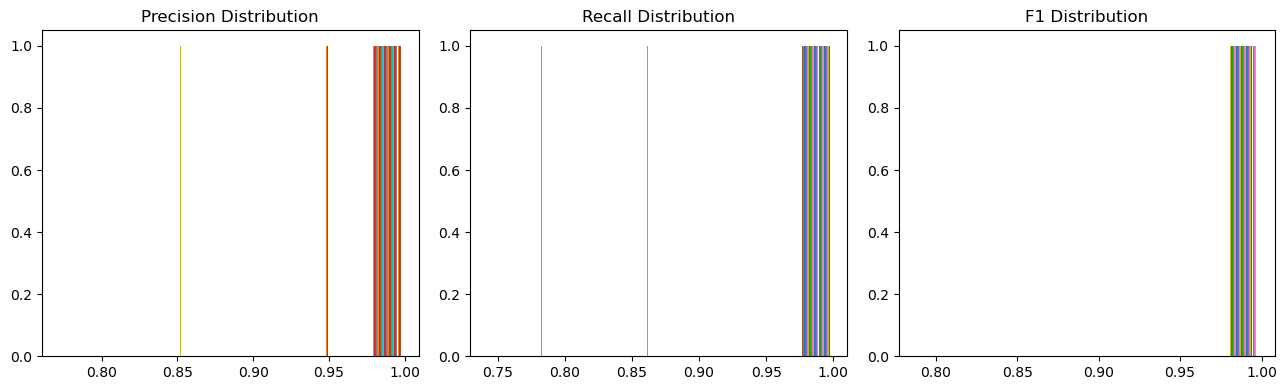

In [181]:
# Visualizing the distribution of f1 scores

f, axs = plt.subplots(1, 3, tight_layout=True, figsize=(13, 4))

axs[0].hist(ds_P, bins=10)
axs[0].set_title("Precision Distribution")

axs[1].hist(ds_R, bins=10)
axs[1].set_title("Recall Distribution")

axs[2].hist(ds_F1, bins=10)
axs[2].set_title("F1 Distribution")

plt.show()

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


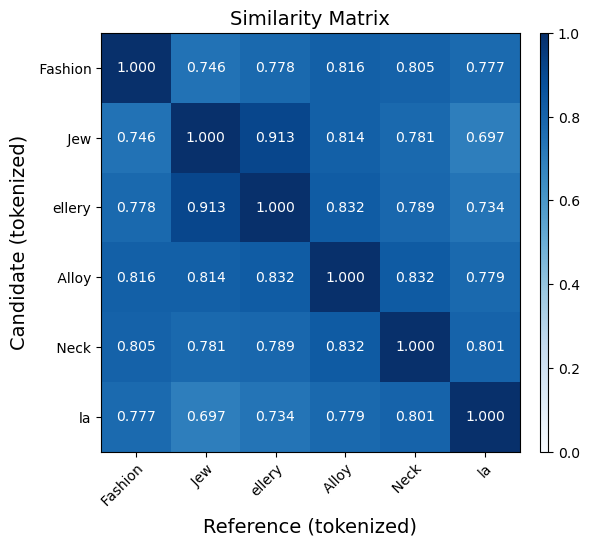

In [ ]:
# Visualize token-wise similarity in the sample
plot_example(response["content"][0]["text"][:30], sample_row[5][:30], lang="en")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


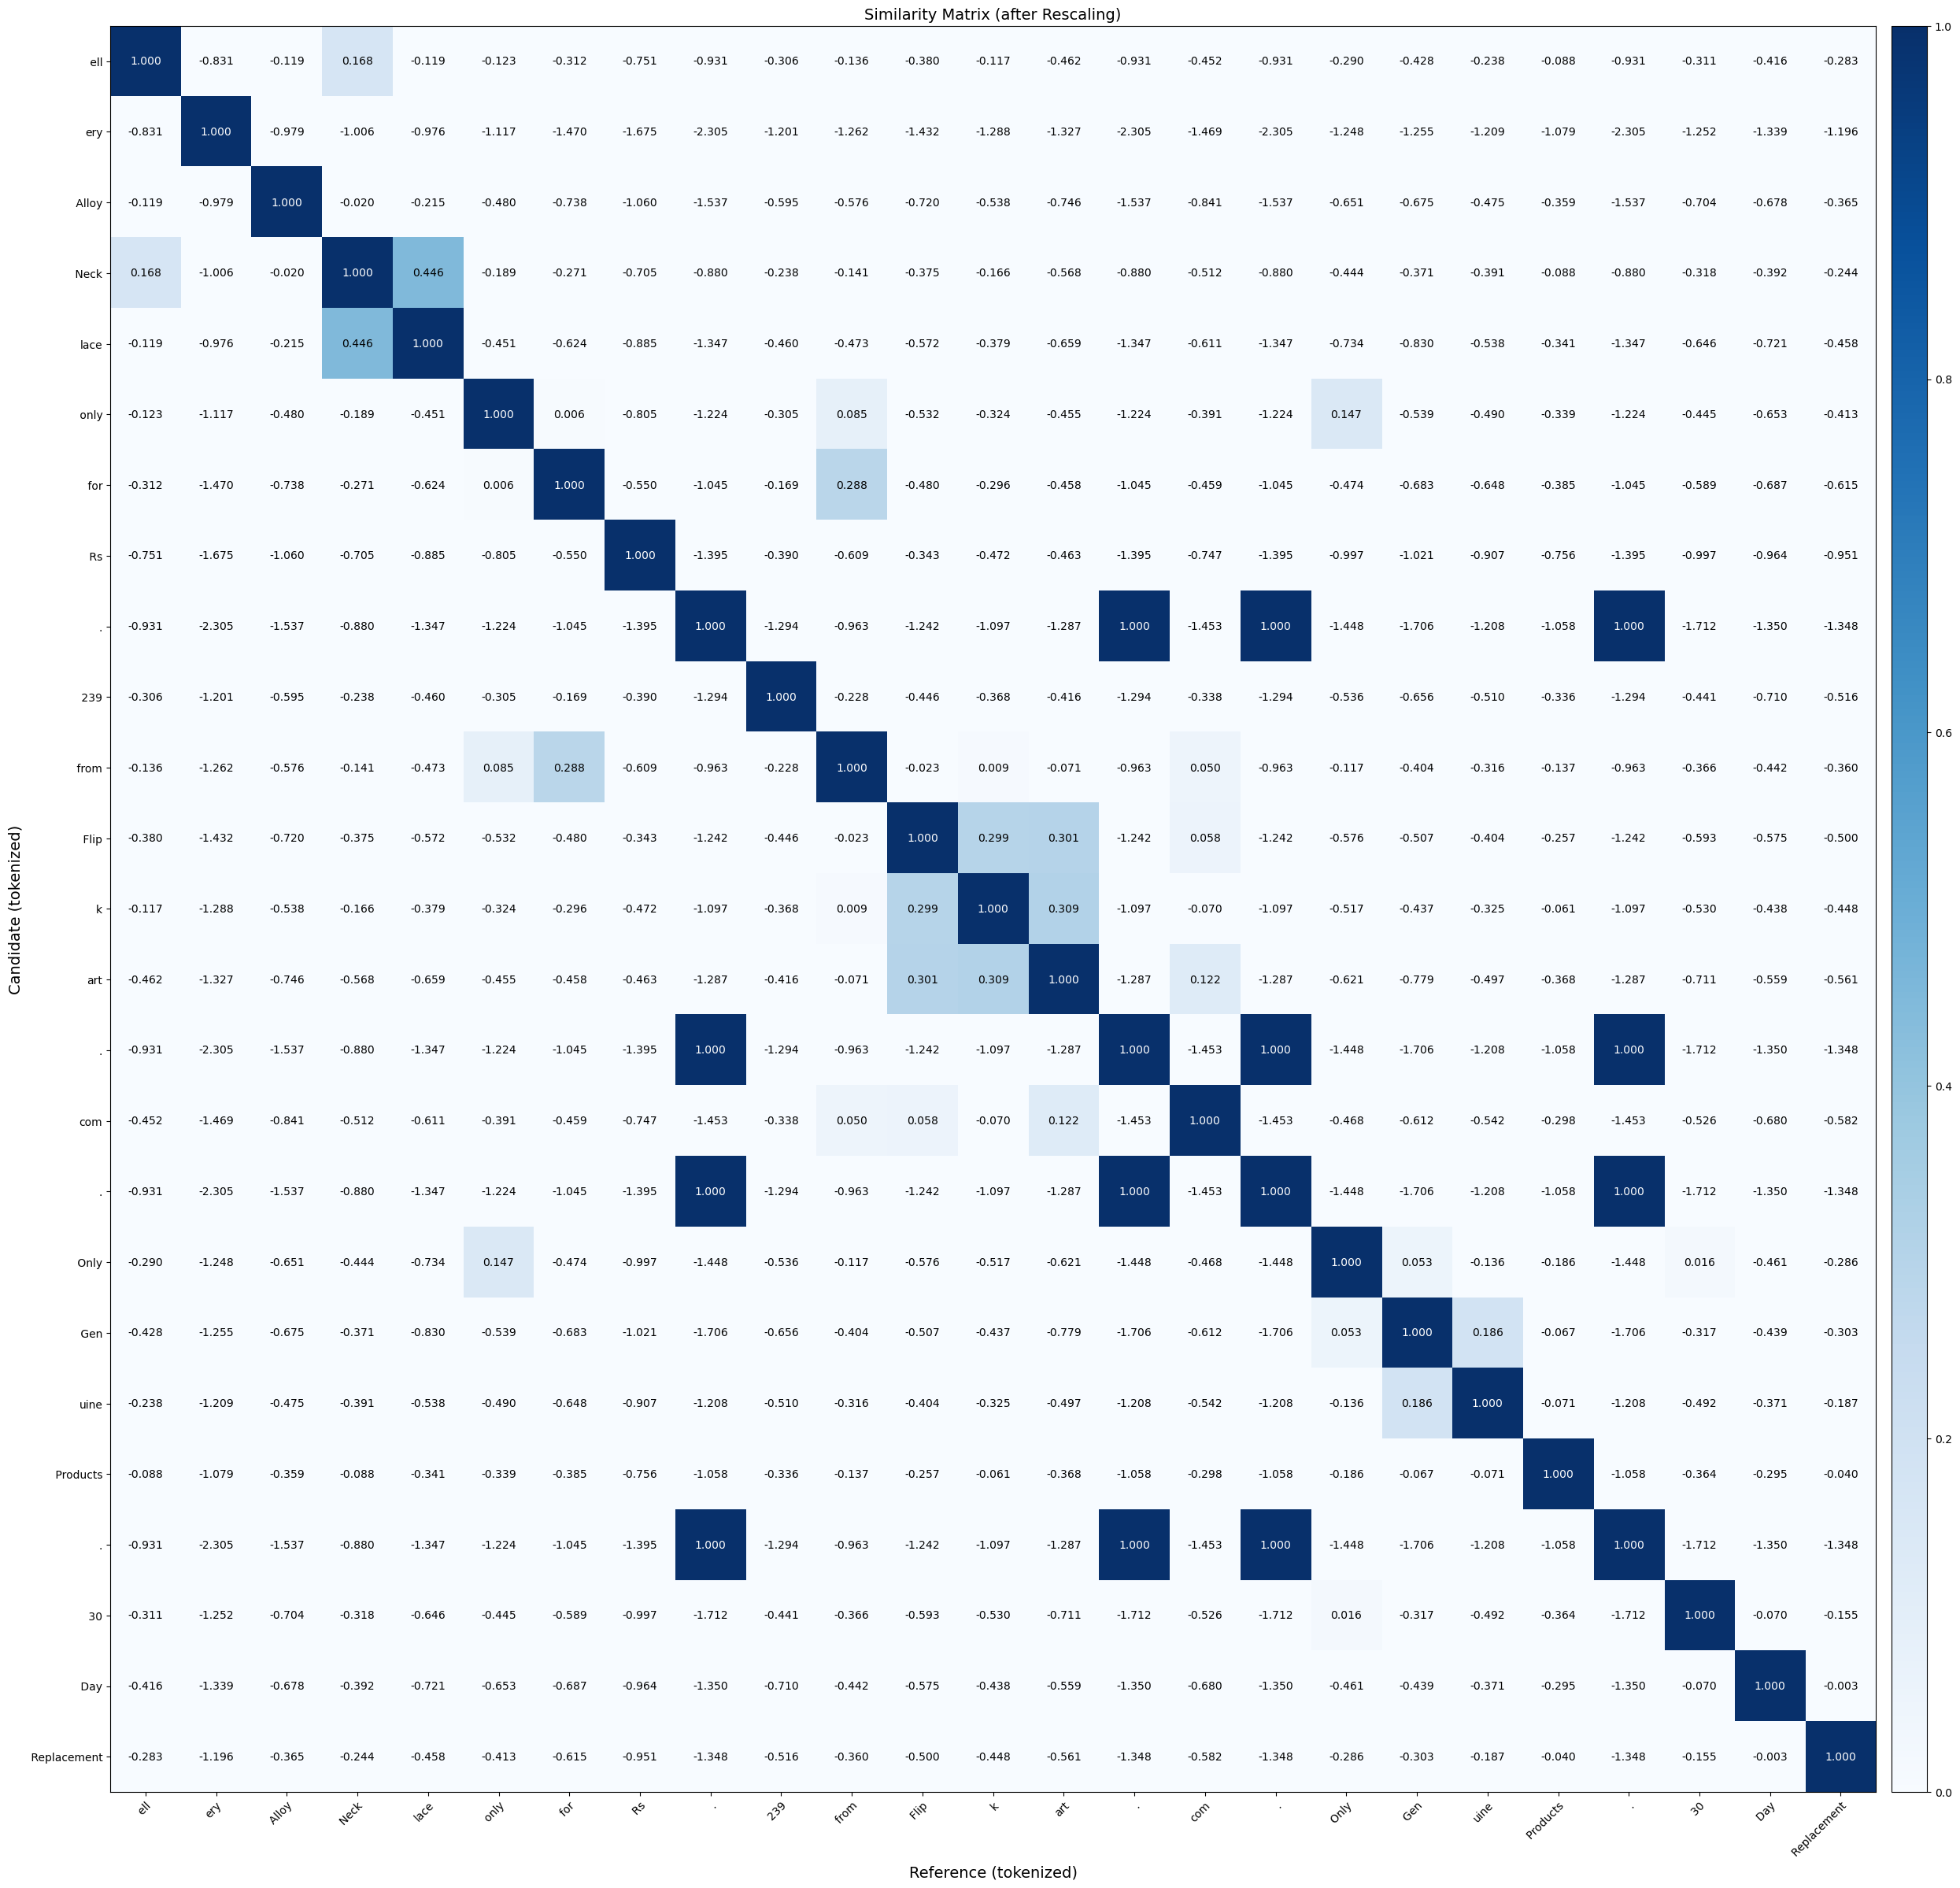

In [144]:
# Visualize token wise similarity in the sample with baseline rescaling
plot_example(response["content"][0]["text"][50:150], sample_row[5][50:150], 
             lang="en", rescale_with_baseline=True)

### Saving prediction results

In [ ]:
# Saving trial parameters and results
ds_P, ds_R, ds_F1 = np.array(ds_P), np.array(ds_R), np.array(ds_F1)

params = {"Model hyperparameters": 
          {"model_id": p.model_id, "model_class": p.model_class, "seed": p.seed,
           "num_few_shot_examples" : p.num_examples, "max_output" : p.max_output_token, 
           "temperature" : p.temperature, "top_p" : p.top_p, },
          "Results: " : {
          "avg_precision" : str(np.mean(ds_P)), "avg_recall" : str(np.mean(ds_R)), "avg_f1" : str(np.mean(ds_F1)), 
              "f1_median": str(np.median(ds_F1)), "f1_std": str(np.std(ds_F1)), 
              "f1_peak_to_peak" : str(np.ptp(ds_F1)), "f1_95_quart" : str(np.quantile(ds_F1, .95)),
          }
         }

trial_id = "trial_" + str(time.strftime("%d_%H_%M_%S", time.gmtime()))
log_exp(trial_id, params)

In [133]:
params

{'Model hyperparameters': {'model_id': 'anthropic.claude-3-5-sonnet-20240620-v1:0',
  'model_class': 'sonnet',
  'Seed': 476,
  'num_few_shot_examples': 3,
  'max_output': 200,
  'temperature': 0.1,
  'top_p': 0.9},
 'Results: ': {'avg_precision': '0.9921571',
  'avg_recall': '0.9892773',
  'avg_f1': '0.99062467',
  'median': 1.0,
  'std': 0.039801233,
  'f1_peak_to_peak': '0.2144379',
  'f1_95_quart': 1.0000001192092896}}